In [2]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modeling prior predictive distribution

The prior should have a mean of 0.2. To calculate the values of the parameters α and β of a beta distribution, we can use the following formulas:

$\alpha =\mu \cdot \left(\frac{\mu \cdot (1-\mu)}{\sigma^2} - 1\right)$  
$\beta = (1-\mu) \cdot \left(\frac{\mu \cdot (1-\mu)}{\sigma^2} - 1\right)$

Let's use a variance of 0.01, which corresponds to a standard deviation of 0.1.

Using the formulas above, we get:

$\alpha \approx 3$  
$\beta \approx 12$

In [10]:
%%writefile code_1.stan

generated quantities {
    int<lower=1> N = 50;
    int<lower=0, upper=N> y;
    real<lower=0, upper=1> p;
    
    p = beta_rng(3, 12);
    y = binomial_rng(N, p);
}

Overwriting code_1.stan


In [31]:
gen_quant = CmdStanModel(stan_file='code_1.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


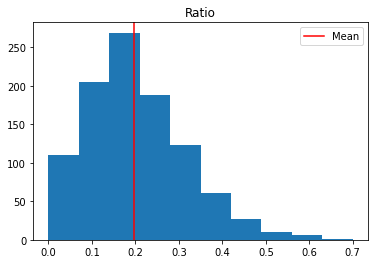

In [33]:
# Generate 1000 samples
samples = gen_quant.sample(fixed_param=True, 
                           iter_sampling=1000)

df = samples.draws_pd()
ratio = df['y'] / df['N']

plt.hist(ratio)
plt.axvline(ratio.mean(), color='r', label="Mean")
plt.title("Ratio")
plt.legend()
plt.show()

# Modeling posterior and posterior predictive distribution

In [26]:
%%writefile code_2.stan

data {
    int<lower=1> N;
    int<lower=0,upper=N> y;
}

parameters {
    real<lower=0, upper=1> p;
}

model {
    p ~ beta(3, 12);
    y ~ binomial(N, p);
}

generated quantities {
    int<lower=0, upper=N> y_pred = binomial_rng(N, p);
}

Overwriting code_2.stan


In [38]:
gen_quant = CmdStanModel(stan_file='code_2.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


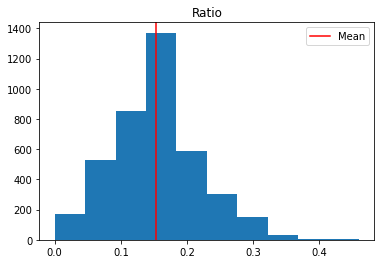

In [41]:
samples = gen_quant.sample(data={'N': 50, 'y': 7})
df = samples.draws_pd()
ratio = df['y_pred'] / 50

plt.hist(ratio)
plt.axvline(ratio.mean(), color='r', label="Mean")
plt.title("Ratio")
plt.legend()
plt.show()

In [45]:
# Compute the expected value and 94% density interval of parameter p
p_mean = df['p'].mean()
p_ci = az.hdi(df['p'].to_numpy(), hdi_prob=0.94)

# Compute the 94% density interval of the predicted ratio
ratio_ci = az.hdi(ratio.to_numpy(), hdi_prob=0.94)

# Print the results
print(f"Parameter p: mean={p_mean:.3f}, 94% CI={p_ci}")
print(f"Predicted ratio: mean={ratio.mean():.3f}, 94% CI={ratio_ci}")

Parameter p: mean=0.153, 94% CI=[0.0741412 0.234724 ]
Predicted ratio: mean=0.153, 94% CI=[0.02 0.26]


In [46]:
print(f"Probability of ratio being lower than average probability from traditional vaccines: {np.sum(ratio < 0.2) / len(ratio)}")

Probability of ratio being lower than average probability from traditional vaccines: 0.72975
